In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.regularizers import l2

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Train MobileNetV3
To train our neural network we need:
 - Load the data
 - Downscale data and prepare it for input
 - create some neccessary functions to show image, show scores and etc
 - Load MobileNetV3 pretrained model without top
 - Prepare Data augmentation layers
 - Prepare output layers
 - Set neccessary parameters
 - Train the model
 - evaluate the model performance
 - create pipeline 

#### parameters initialization

In [2]:
# We need to set seed for any randomizing that will happen during process
SEED = 44
# choose how much times we want data to be shown
epochs = 40
BATCH_SIZE = 32
# validation frequency so validation wont be run every epoch
VAL_FREQ = 2
OPTIMIZER = 'adam'
shape =  112
shape_mobilenet = 96
input_shape = (shape,shape,3)

# Create Data Loader
We need data loader to make loading batches computationally efficient and avoid memory issues

In [3]:
def load_from_directory(filename):
    data = tf.keras.utils.image_dataset_from_directory(filename,batch_size=BATCH_SIZE,image_size=(shape,shape),seed=SEED,labels="inferred",label_mode="int")
    return data

# We split our dataset into train and validation sets
def split_dir_dataset(data):
    # scale down rgb from 255 to 0
    data = data.map(lambda x,y: (x/255,y))
    
    # percent size of train and val sets
    train_size = int(len(data)*.85)
    test_size = int(len(data) * .10)
    val_size = int(len(data)*.05)
    
    
    # take that size images from dataset
    train = data.take(train_size)
    test = data.skip(train_size).take(test_size)
    val = data.skip(train_size+test_size).take(val_size)
    
    
    print(f'training shape: {train.as_numpy_iterator().next()[0].shape}')
    return train,test,val

In [4]:
# path to our dataset
dataset_path = './multiclass'

data = load_from_directory(dataset_path)

train,test, val = split_dir_dataset(data)


Found 712745 files belonging to 2 classes.
training shape: (32, 112, 112, 3)


In [5]:
output_len = len(data.class_names)
print(output_len)

2


# Necessary Functions
Now we have to initialize necessary functions that we will use later


In [6]:
def show_samples_dataset(data):
    class_names = data.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
          
def show_results(hist,mode='acc'):
    if mode == 'acc' or mode == 'accuracy':
        mode = 'accuracy'
        val_mode = 'val_accuracy'
    elif mode == 'loss':
        mode = "loss"
        val_mode = "val_loss"
    
    fig = plt.figure()
    plt.plot(hist.history[mode], color='teal', label=mode)
    plt.plot(hist.history[val_mode], color='orange', label=val_mode)
    fig.suptitle(mode, fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
    
def prediction_dir_dataset(model,test,data):
    y_true = []
    y_pred = []
    length = int(len(data) * .10)
    index = 0
    for batch in test.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        yhat = np.argmax(yhat,axis=1)
        y_true.append(y)
        y_pred.append(yhat)
        print(f"Progress: {index}/{length}", end='\r')
        index += len(batch)
    y_true = np.array(y_true)
    y_true = y_true.reshape(-1)
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    
    return y_true,y_pred

def scores(y_true,y_pred,show_confusion_matrix=True):
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    if show_confusion_matrix == True:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    print(f"precision weighted: {'{:.3f}'.format(precision_weighted)}\nprecision micro: {precision_micro} ")
    print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
    print(f'f1 weighted: {"{:.3f}".format(f1_weighted)}\nf1 micro: {f1_micro} ')

# Add Data augmentation to our model

In [7]:
def data_augment(X):
    X = RandomCrop(height=shape_mobilenet,width=shape_mobilenet,seed=SEED)(X)
    X = RandomFlip(mode="horizontal_and_vertical",seed=SEED)(X)
    X = RandomRotation(factor=0.5)(X)
    X = RandomContrast(0.8,seed=SEED)(X)
    return X

# Load the model

In [8]:
base_model = MobileNetV3Large(input_shape=(shape_mobilenet,shape_mobilenet,3),weights='imagenet',include_top=False,include_preprocessing=False)


In [9]:
# initialize input shape layer for data augmentation block
x_input = Input(input_shape)
x = data_augment(x_input)

# connect data augmentation block to base model
x = base_model(x)


# Global spatial avg pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layer
x = Dense(1024,activation='relu',kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)



# We have 2 classes either it is suitable for children or not
predictions = Dense(output_len,activation='softmax')(x)

# this is the model we will train
model = Model(inputs=x_input, outputs=predictions)

In [10]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNetV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [11]:
# visualize model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0     

In [12]:
# initialize this so computing is more efficient
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# # train = train.cache()
# train = train.prefetch(buffer_size=AUTOTUNE)

# Define callbacks
checkpoint = ModelCheckpoint('mobilenet_best_l2_112_1024.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

In [13]:
# train the model on the new data for a few epochs
epochs = 2

hist = model.fit(train,
                 epochs = epochs,
                 validation_data=val,
                 callbacks = [checkpoint,early_stopping]
                 # ,validation_freq=VAL_FREQ
                )

Epoch 1/2
18932/18932 [==============================] - 612s 32ms/step - loss: 0.5242 - accuracy: 0.8195 - val_loss: 0.4107 - val_accuracy: 0.8542


C:\Users\warfa\.conda\envs\AI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/2
 2341/18932 [==>...........................] - ETA: 6:24 - loss: 0.4662 - accuracy: 0.8221

KeyboardInterrupt: 

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0     

In [15]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from MobileNet V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 random_crop
2 random_flip
3 random_rotation
4 random_contrast
5 MobilenetV3large
6 global_average_pooling2d_1
7 dense
8 dropout
9 dense_1


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0     

In [17]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
   layer.trainable = True

In [18]:
checkpoint = ModelCheckpoint('mobilenet_best_unfrozen_l2_112_1024.h5', monitor='val_loss', save_best_only=True, mode='min')

In [19]:
# we need to recompile the model for these modifications to take effect
# we use adam with a low learning rate
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0     

In [21]:
# we train our model again, this time fine-tuning the convolutional layers
# alongside the top Dense layers
epochs = 5
hist_unfreezed = model.fit(train,
                 epochs = epochs,
                 validation_data=val,
                 callbacks = [checkpoint,early_stopping]
                 # ,validation_freq=VAL_FREQ
                )
#  https://keras.io/api/applications/#usage-examples-for-image-classification-models

Epoch 1/5
18932/18932 [==============================] - 1410s 74ms/step - loss: 0.2071 - accuracy: 0.9239 - val_loss: 0.2355 - val_accuracy: 0.9083
Epoch 2/5
18932/18932 [==============================] - 1389s 73ms/step - loss: 0.1467 - accuracy: 0.9458 - val_loss: 0.2583 - val_accuracy: 0.9144
Epoch 3/5
18932/18932 [==============================] - 1398s 74ms/step - loss: 0.1312 - accuracy: 0.9517 - val_loss: 0.2025 - val_accuracy: 0.9199
Epoch 4/5
18932/18932 [==============================] - 1473s 78ms/step - loss: 0.1216 - accuracy: 0.9556 - val_loss: 0.4216 - val_accuracy: 0.8826
Epoch 5/5
18932/18932 [==============================] - 1512s 80ms/step - loss: 0.1156 - accuracy: 0.9579 - val_loss: 0.2065 - val_accuracy: 0.9261


In [8]:
def load_model(model_name):
    model = tf.keras.models.load_model(model_name)
    return model

model = load_model('mobilenet.h5')

In [9]:

def predict(img_path):
    # img_path = 'dawg.jpg'
    img = load_img(img_path, target_size=(128, 128))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    predicted_idx = np.argmax(preds)
    predicted_class = data.class_names[predicted_idx]
    print(predicted_class) 

In [25]:
# predict("images (1).jpeg")

In [26]:
data.class_names

['nude', 'safe']

In [11]:
model = load_model("mobilenet_best_unfrozen_l2_112_1024_256.h5")

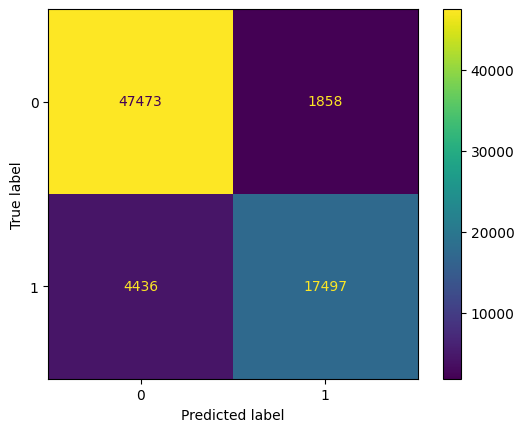

precision weighted: 0.911
precision micro: 0.9116805118994162 
recall weighted: 0.9116805118994162
recall micro: 0.9116805118994162 
f1 weighted: 0.910
f1 micro: 0.9116805118994162 


In [15]:
y_true,y_pred = prediction_dir_dataset(model,test,data)
scores(y_true,y_pred,show_confusion_matrix=True)

In [14]:
print(len(test))

2227


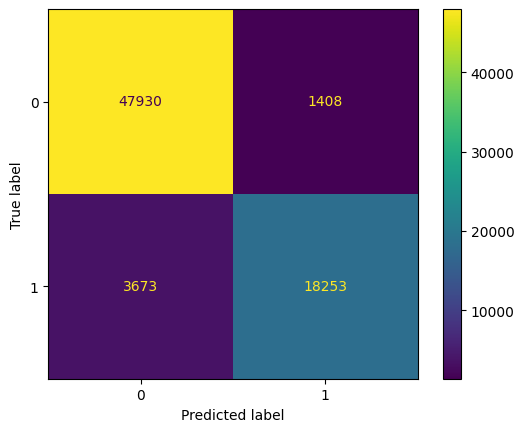

precision weighted: 0.929
precision micro: 0.9287017287831163 
recall weighted: 0.9287017287831163
recall micro: 0.9287017287831163 
f1 weighted: 0.928
f1 micro: 0.9287017287831163 


In [22]:
y_true,y_pred = prediction_dir_dataset(model,test,data)
scores(y_true,y_pred,show_confusion_matrix=True)